# HW_L6

ENGN2912V

Seokkee Min

## P5

In [1]:
import jax
from jax.example_libraries import stax, optimizers
from jax import numpy as jnp
from jax import jit, grad, vmap, random, value_and_grad
import numpy as np
import csv
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
np.random.seed(0)
train_path = "/gpfs/home/smin24/ENGN2912V/HW_L6/mnist_train.csv"
mnist = np.loadtxt(train_path, delimiter = ',', skiprows=1, usecols=range(1,785))
label = np.loadtxt(train_path, delimiter = ',', skiprows=1, usecols=0)

# mnist = mnist.reshape(-1, 28, 28, 1)
mnist /= 255.0

ind = np.arange(mnist.shape[0])
np.random.shuffle(ind)

label = label[ind]

train = mnist[ind][:int(np.floor(mnist.shape[0]*0.8))]
test = mnist[ind][int(np.floor(mnist.shape[0]*0.8)):]

In [3]:
len(train)

48000

In [4]:
len(test)

12000

In [5]:
scalar = StandardScaler();
scalar.fit(train);

In [6]:
train_norm = scalar.transform(train)
test_norm = scalar.transform(test)

COV = train_norm.T @ train_norm
eigvect = np.linalg.eigh(COV)[1]

## Part A - PCA

In [7]:
# manual input number of eigen dimensions (ld)
dim = 10

eigvect_dim = eigvect[:, -dim:]
reconst = (train_norm @ eigvect_dim) @ eigvect_dim.T

In [8]:
def print_img(x, num_img, title):
    if num_img % 10 == 0 and num_img <= 100:
        fig = plt.figure()
        for i in range(0,num_img):
            plt.subplot(int(num_img/10),10,i+1)
            img = x[i].reshape(28,28)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            fig.suptitle(title)


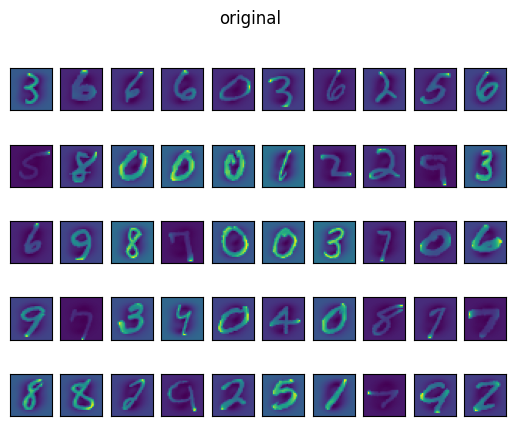

In [9]:
print_img(train_norm, 50, "original")

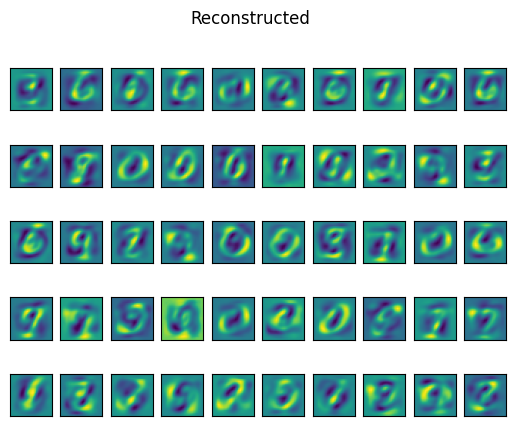

In [10]:
print_img(reconst, 50, "Reconstructed")

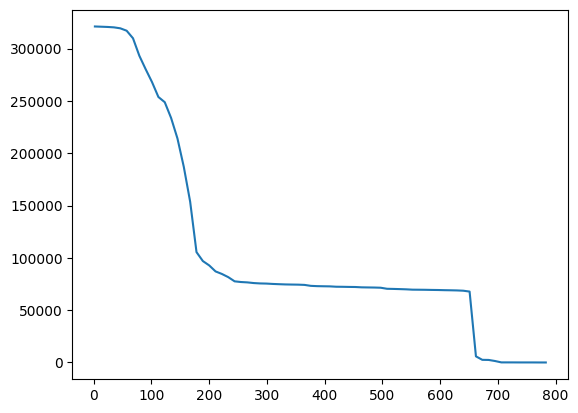

In [11]:
# test avg loss
test_dim = np.arange(2, 28*28, 11)
loss_pca = np.zeros(test_dim.shape)
for i, dim in enumerate(test_dim):
    eigvect_dim = eigvect[:,-dim:]
    recon = (test_norm @ eigvect_dim) @ eigvect_dim.T
    summ = np.sum((test_norm - recon)**2, axis=1)
    loss_pca[i] = summ.mean()
    
plt.plot(test_dim, loss_pca)

Reconstruction loss on the test set decreases as latent dimension increases, before hitting a local plateau, and then drops again after some iterations. For multiple different l_d, local plateau seems to be around 50 to 100k on the y-scale (not normalized error).

## Part B - Autoencoder

In [12]:
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import tqdm
import optax
from functools import partial

In [13]:
# train_imgs = jnp.array(train.astype("float32"))/255.
# test_imgs = jnp.array(test.astype("float32"))/255.

train_imgs = train_norm
test_imgs = test_norm
dataloader_train = jnp.reshape(train_imgs, (len(train_imgs), 28, 28, 1))
dataloader_test = jnp.reshape(test_imgs, (len(test_imgs), 28, 28, 1))

In [14]:
class Autoencoder(nn.Module):
    
    
    @nn.compact
    def __call__(self,x,d_l):
        # encode
        # print(np.shape(x))
        lay: int = d_l
        
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=1, padding="SAME")(x)  # 28x28x1 --> 28x28x32
        # print(np.shape(x))
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2,2), strides=(2, 2))  # 28x28x32 --> 14x14x32
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=1, padding="SAME")(x)  # 14x14x32 --> 14x14x64
        x = nn.relu(x)
        encoded = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))  # 14x14x64 --> 7x7x64
        
        # 
        # print(np.shape(encoded))
        x = encoded.reshape((encoded.shape[0], -1))    # flatten
        # print(np.shape(x))
        x = nn.Dense(features = lay)(x)
        # print(np.shape(x))
        
        # decode
        x = nn.Dense(features = 3136)(x)
        x = x.reshape(encoded.shape)
        # print(np.shape(x))
        x = nn.relu(x)
        x = nn.ConvTranspose(features=32, kernel_size=(2, 2), strides=(2, 2), padding="SAME")(x) # 7x7x64 --> 14x14x32
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=1, padding="SAME")(x)  # 14x14x32 --> 14x14x32
        x = nn.relu(x)

        x = nn.ConvTranspose(features=16, kernel_size=(2, 2), strides=(2, 2), padding="SAME")(x) # 14x14x32 --> 28x28x16
        x = nn.sigmoid(x)
        decoded = nn.Conv(features=1, kernel_size=(3, 3), strides=1, padding="SAME")(x)  # 28x28x16 --> 28x28x1
        # print(np.shape(decoded))

        return decoded

In [15]:
def loss_fn(params, imgs, d_l):
    recon = Autoencoder().apply({"params":params}, imgs, d_l)
    # print(np.shape(recon))
    # loss = ((recon-imgs)**2).mean(axis=0).sum()
    summ = jnp.sum((recon - imgs)**2, axis=1)
    loss = summ.mean()
    return loss, recon

In [16]:
# def l2_loss(x, alpha):
#     return alpha* (x**2).mean()

In [17]:
# def loss_fn(params, batch):
#     recon, _ = Autoencoder().apply({"params":params}, batch)
#     loss = jnp.mean((recon.flatten()-batch.flatten())**2)
#     loss += sum(l2_loss(w, alpha=0.001) for w in jax.tree_leaves(params))
#     return loss, recon

In [18]:
def create_train_state(rng, lr, d_l):
    model = Autoencoder()
    params = model.init(rng, jnp.ones([1,28,28,1]), d_l)["params"]
    # print(np.shape(params))
    tx = optax.adam(lr)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

@partial(jax.jit, static_argnames=['d_l'])
def train_step(state, img, d_l):
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    # print(np.shape(state.params))
    (loss, recon), grads = grad_fn(state.params, img, d_l)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [19]:
def train_epoch(state, train_imgs, batch_size, epoch, rng, d_l):

    num_train_imgs = len(train_imgs)
    steps_per_epoch = num_train_imgs//batch_size
    
    perms = jax.random.permutation(rng, num_train_imgs)
    perms = perms[:steps_per_epoch*batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_loss = []
    
    for perm in perms:
        batch = train_imgs[perm]
        state, loss = train_step(state, batch, d_l)
        batch_loss.append(loss)
        
    average_loss = jnp.mean(jnp.array(batch_loss))
    
    print("d_l: %d, train epoch: %d, loss: %.4f" % (d_l, epoch, average_loss))
    
    return state

In [20]:
test_d = [2, 10, 50, 100, 200, 300 , 400, 500, 600, 700]

test_losses = np.zeros(len(test_d))
rng = random.PRNGKey(1234)
init_rng, batch_rng = jax.random.split(rng,2)
lr = 0.001
epochs = 10
batch_size = 1000
loss_nn = np.zeros(len(test_d))
recon_nn = np.zeros((len(test_d), 12000, 28, 28, 1))


In [21]:
for count, d_l in enumerate(test_d):
    state = create_train_state(init_rng, lr, d_l)
    for epoch in range(1, epochs +1):
        state = train_epoch(state, dataloader_train, batch_size, epoch, batch_rng, d_l)   
    loss , recon_test = loss_fn(state.params, dataloader_test, d_l)
    # print(np.shape(recon_test))
    loss_nn[count] = loss
    recon_nn[count] = recon_test    

2023-05-02 11:44:03.491874: W external/xla/xla/service/gpu/gpu_conv_algorithm_picker.cc:850] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-05-02 11:44:03.491913: W external/xla/xla/service/gpu/gpu_conv_algorithm_picker.cc:853] Conv: (f32[32,64,2,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1000,14,14]{3,2,1,0}, f32[64,1000,13,13]{3,2,1,0}), window={size=13x13 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


d_l: 2, train epoch: 1, loss: 26.3281
d_l: 2, train epoch: 2, loss: 24.7030
d_l: 2, train epoch: 3, loss: 23.4320
d_l: 2, train epoch: 4, loss: 22.4024
d_l: 2, train epoch: 5, loss: 21.8573
d_l: 2, train epoch: 6, loss: 21.4695
d_l: 2, train epoch: 7, loss: 21.1393
d_l: 2, train epoch: 8, loss: 20.8430
d_l: 2, train epoch: 9, loss: 20.5933
d_l: 2, train epoch: 10, loss: 20.3827
d_l: 10, train epoch: 1, loss: 26.2347
d_l: 10, train epoch: 2, loss: 23.4173
d_l: 10, train epoch: 3, loss: 19.0241
d_l: 10, train epoch: 4, loss: 16.3830
d_l: 10, train epoch: 5, loss: 15.0228
d_l: 10, train epoch: 6, loss: 14.1374
d_l: 10, train epoch: 7, loss: 13.4695
d_l: 10, train epoch: 8, loss: 12.9619
d_l: 10, train epoch: 9, loss: 12.5408
d_l: 10, train epoch: 10, loss: 12.1889
d_l: 50, train epoch: 1, loss: 25.6890
d_l: 50, train epoch: 2, loss: 18.9492
d_l: 50, train epoch: 3, loss: 13.8931
d_l: 50, train epoch: 4, loss: 11.7755
d_l: 50, train epoch: 5, loss: 10.6230
d_l: 50, train epoch: 6, loss: 9.

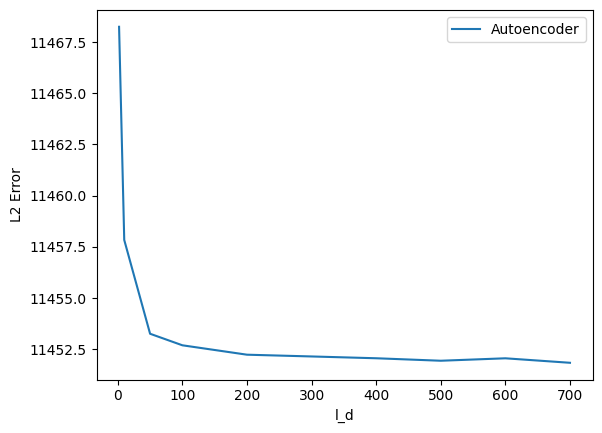

In [28]:
plt.plot(test_d, loss_nn, label = "Autoencoder")
plt.legend();
plt.xlabel("l_d");
plt.ylabel("L2 Error");

For an autoencoder, the loss rapidly drops off for very low latent_dimensions. By l_d = 100, the error floor is approximately reached. Noting the y-scale, the overall drop is small. Even for the batch error during training, the error is relatively stable for different l_d, with some minor decreases as l_d increases.

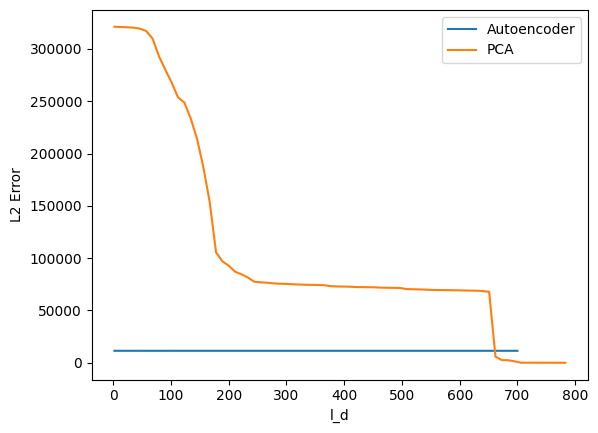

In [22]:
plt.plot(test_d, loss_nn, label = "Autoencoder")
plt.plot(test_dim, loss_pca, label = "PCA")
plt.legend()
plt.xlabel("l_d")
plt.ylabel("L2 Error")
plt.show()

Comparing the L2 error for an autoencoder and PCA, as a function of latent dimensions (l_d). When the errors of the two methods are shown side by side, we can really appreciate how flat the error is for an autoencoder for different l_d sizes, compared to PCA. 

PCA has major issues in reconstructing the MNIST data at lower dimensions, but shows rapid improvement in decreasing the error, with 3 different plateaus (approx 1 to 60, 200 to 650, and 660 onward) where some of the pixels change very little for all examples (e.g. boarders, writing is always centered, and the center that usually has some overlapping writing). With regions of very little change, the dimensions here do not matter and their variance should be small enough that their eigenvectors can be ignored during reconstruction.  

The autoencoder probably doesn't suffer the same issues, as the convolutional layers better compress the important information and can send it to the latent dimension embedding. As shown below, for a l_d = 10, the autoencoder vastly outperforms PCA.

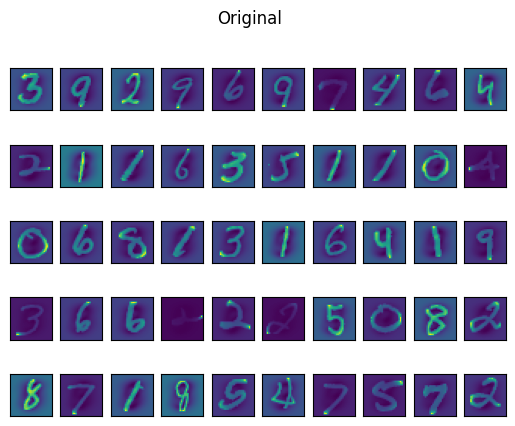

In [23]:
print_img(dataloader_test, 50, "Original")

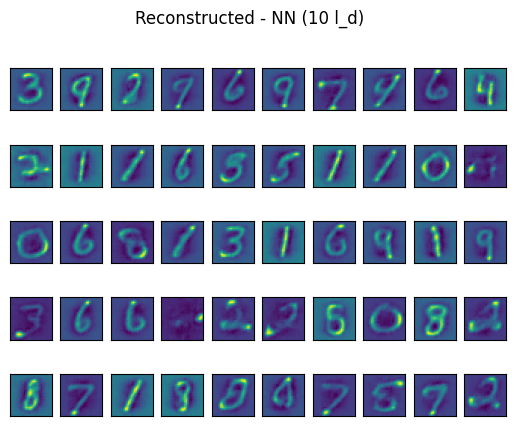

In [25]:
print_img(recon_nn[1], 50, "Reconstructed - NN (10 l_d)")

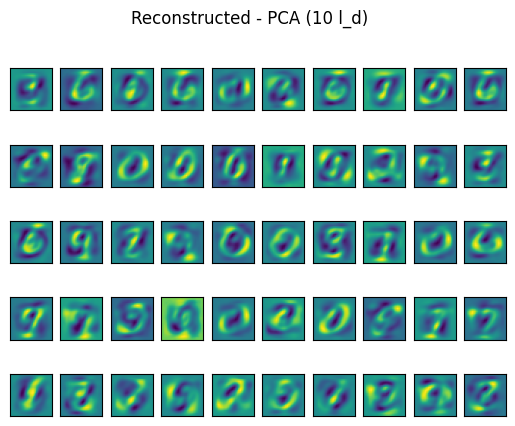

In [26]:
print_img(reconst, 50, "Reconstructed - PCA (10 l_d)")